# Hit classification

In this notebook we will try to use Keras and XGBoost in order to distinguish between _true_ conversion electron hits and _fake_ conversion electron hits.

In [1]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

2022-12-07 15:00:39.700509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First of all we use [uproot](https://uproot.readthedocs.io/en/latest/), a library to reading ROOT files in pure Python and NumPy, to open the `trkana` tree in the `TAKK` folder of the `KKSM01.root` file. We only need certain branches, so we apply a filter to read only `de`, `detsh`, `detshmc`, and `demc`. We then apply a mask to our tree to select only good fits. 

In [2]:
files = ["nts.brownd.KKSeed.KKSM.001210_00000005.root", "nts.brownd.KKSeed.KKSM.001210_00000008.root", "nts.brownd.KKSeed.KKSM.001210_00000011.root", "nts.brownd.KKSeed.KKSM.001210_00000059.root"]



Then, we select the first 10000 events in the tree and concatenate the lists of the hit variables in a single, large array. These 5 arrays are then stacked in a single bi-dimensional array with `np.vstack`, which will be our input dataset used for the training of the machine learning algorithms.

In [3]:
with uproot.open("nts.brownd.KKSeed.KKSM.001210_00000005.root") as file:
    trkana3 = file["TAKK"]["trkana"].arrays(filter_name="/de|detsh|detshmc|demc/i")
    trkana3 = trkana3[(trkana3['de.goodfit']==1)&(trkana3['de.status']>0)&(trkana3['demc.proc']==167)]
 

In [4]:
with uproot.open("nts.brownd.KKSeed.KKSM.001210_00000008.root") as file:
    trkana4 = file["TAKK"]["trkana"].arrays(filter_name="/de|detsh|detshmc|demc/i")
    trkana4 = trkana4[(trkana4['de.goodfit']==1)&(trkana4['de.status']>0)&(trkana4['demc.proc']==167)]


In [5]:

input_dataset = np.empty
temp = np.empty
mcrel = []
n_events = 100000

for filename in files:
    with uproot.open(filename) as file:
        trkana = file["TAKK"]["trkana"].arrays(filter_name="/de|detsh|detshmc|demc/i")
        trkana = trkana[(trkana['de.goodfit']==1)&(trkana['de.status']>0)&(trkana['demc.proc']==167)]
        
    print("Processing: " + filename)    
    udt = np.add(ak.concatenate(trkana['detsh.udt'][:n_events]).to_numpy(), ak.concatenate(trkana['detsh.udt'][:n_events]).to_numpy())  
    udoca = ak.concatenate(trkana['detsh.udoca'][:n_events]).to_numpy()
    tottdrift = ak.concatenate(trkana['detsh.tottdrift'][:n_events]).to_numpy()
    rdrift = ak.concatenate(trkana['detsh.rdrift'][:n_events]).to_numpy()
    edep = ak.concatenate(trkana['detsh.edep'][:n_events]).to_numpy()
    udocavar = ak.concatenate(trkana['detsh.udocavar'][:n_events]).to_numpy()
    wdist = ak.concatenate(trkana['detsh.wdist'][:n_events]).to_numpy()
    uupos = ak.concatenate(trkana['detsh.uupos'][:n_events]).to_numpy()
    rho = np.square(ak.concatenate(trkana['detsh.poca.fCoordinates.fX'][:n_events]).to_numpy())
    rho = np.add(rho,np.square(ak.concatenate(trkana['detsh.poca.fCoordinates.fY'][:n_events]).to_numpy()))
    rho = np.sqrt(rho)
    
    temp = np.vstack((udt,udoca,tottdrift,rdrift,edep, udocavar, wdist, uupos, rho)).T
    if input_dataset is np.empty:
        input_dataset = temp
    else:
        input_dataset = np.concatenate((input_dataset, temp))
        
    for i, this_dt in enumerate(trkana['detsh.udt'][:n_events]):
        mcrel.extend(trkana['detshmc.rel._rel'][i][:len(this_dt)])



Processing: nts.brownd.KKSeed.KKSM.001210_00000005.root
Processing: nts.brownd.KKSeed.KKSM.001210_00000008.root
Processing: nts.brownd.KKSeed.KKSM.001210_00000011.root
Processing: nts.brownd.KKSeed.KKSM.001210_00000059.root


Here we then assign a label to each hit as _signal_ or _background_, depending on the Monte Carlo truth information. Since the dimension of  `detshmc.rel._rel` is not guaranteed to be the same as the dimension of `detsh` we need to loop over all the entries.

In [6]:
# mcrel = []

# for i, this_dt in enumerate(trkana['detsh.udt'][:n]):
#     mcrel.extend(trkana['detshmc.rel._rel'][i][:len(this_dt)])
    
mcrel = np.array(mcrel)
true_ce = mcrel==0
    
signal = true_ce
bkg = mcrel ==-1

In our problem we have a different number of signal and background entries in our input dataset. There are several techniques avaialable for _unbalanced_ datasets. Here we are using the most naive one, which is just using $\min(N_{sig}, N_{bkg})$ events. Then, we divide our input into the _training_, _validation_, and _test_ datasets.

In [7]:
min_len = min(len(input_dataset[signal]), len(input_dataset[bkg]))

signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[bkg][:min_len]

balanced_input = np.concatenate((signal_dataset, bkg_dataset))
y_balanced_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))

n_variables = balanced_input.shape[1]

x_ce_train, x_ce_test, y_ce_train, y_ce_test = train_test_split(balanced_input, y_balanced_input, test_size=0.5, random_state=42)
x_ce_test, x_ce_valid, y_ce_test, y_ce_valid = train_test_split(x_ce_test, y_ce_test, test_size=0.5, random_state=42)

## Create and train a multi-layer perceptron

Here we create a _multi-layer perceptron_ (MLP) model which consists of 3 fully-connected (or _dense_) layers, each one followed by a _dropout_ layer, which helps to avoid overfitting. The model is trained using the [Adam](https://arxiv.org/abs/1412.6980) optimizer and trained for 50 epochs or until the validation loss doesn't improve for 5 epochs (`early_stop`). 

In [8]:
# set up tensorboard


In [19]:
opt = Adam(learning_rate=1e-3)

model_ce = Sequential()
model_ce.add(Dense(n_variables+1, activation='relu', input_shape=(n_variables,)))
#model_ce.add(Dropout(0.00005))
model_ce.add(Dense(n_variables+1, activation='relu'))
#model_ce.add(Dropout(0.00005))
model_ce.add(Dense(n_variables+1, activation='relu'))
#model_ce.add(Dropout(0.00005))
model_ce.add(Dense(1, activation='sigmoid'))
model_ce.compile(loss='binary_crossentropy',
                 metrics='accuracy',
                 optimizer=opt)

early_stop = EarlyStopping(monitor='val_loss', patience=5)
history_ce = model_ce.fit(x_ce_train, y_ce_train,
                          epochs=50,
                          verbose=1,
                          validation_data=(x_ce_valid, y_ce_valid),
                          callbacks=[early_stop])
#early stop-- what is the threshold? can this be improved 
# need to add tensorboard in callbacks

#save the model in an h5
model_ce.save("KKtrainModel.h5")


Epoch 1/50
737/737 [==============================] - 1s 976us/step - loss: 1.2589 - accuracy: 0.7742 - val_loss: 0.6523 - val_accuracy: 0.7828
Epoch 2/50
737/737 [==============================] - 1s 887us/step - loss: 0.5484 - accuracy: 0.8013 - val_loss: 0.5128 - val_accuracy: 0.8171
Epoch 3/50
737/737 [==============================] - 1s 847us/step - loss: 0.4950 - accuracy: 0.8090 - val_loss: 0.7838 - val_accuracy: 0.7815
Epoch 4/50
737/737 [==============================] - 1s 843us/step - loss: 0.4724 - accuracy: 0.8183 - val_loss: 0.4601 - val_accuracy: 0.8140
Epoch 5/50
737/737 [==============================] - 1s 849us/step - loss: 0.4505 - accuracy: 0.8277 - val_loss: 0.4317 - val_accuracy: 0.8393
Epoch 6/50
737/737 [==============================] - 1s 851us/step - loss: 0.4263 - accuracy: 0.8354 - val_loss: 0.4194 - val_accuracy: 0.8384
Epoch 7/50
737/737 [==============================] - 1s 846us/step - loss: 0.4089 - accuracy: 0.8423 - val_loss: 0.3942 - val_accuracy:

In [ ]:
plt.plot(history_ce.history['val_loss'],label="val loss")
plt.plot(history_ce.history['loss'],label="loss")
plt.legend()

%load_ext tensorboard
#rm -rf ./logs/
%tensorboard --logdir logs/fit


## Create and train a Boosted Decision Tree
Here, instead of using a MLP, we use a [_Gradient Boosted Decision Tree_](https://xgboost.readthedocs.io/en/stable/) (BDT) to distinguish between signal (true CE hits) and background (fake CE hits). We use the defualt hyperparameters.

In [ ]:
model_xgboost = XGBClassifier()
model_xgboost.fit(x_ce_train, y_ce_train)

Here we can finally apply our two models (the MLP and the BDT) to our test datasets and create the corresponding ROC curves.

In [ ]:
prediction_ce = model_ce.predict(x_ce_test).ravel()
fpr_ce, tpr_ce, th_ce = roc_curve(y_ce_test,  prediction_ce)
auc_ce = roc_auc_score(y_ce_test, prediction_ce)

In [ ]:
prediction_xgboost = model_xgboost.predict_proba(x_ce_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_ce_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_ce_test, prediction_xgboost)

The plot of the ROC curves clearly shows that the BDT outperforms the MLP. In principle, however, it should be possible to improve the MLP performances by optimizing the hyperparameters (learning rate, hidden layers, activation functions, etc.).

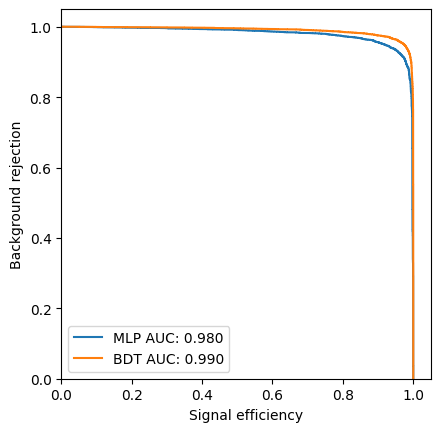

In [18]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr_ce,1-fpr_ce,label=f'MLP AUC: {auc_ce:.3f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.3f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0,1.05)
ax.set_ylim(0,1.05)
fig.savefig("truece.pdf")

In [15]:
#n_variables+1 and No dropout

In [16]:
# make environemnt variable before call jypter notebook return in cori
#try n+1 on layers with 3 digits
#early stop-- what is the threshold? can this be improved 
#graphs --r
# sit down with jennifer an consolodate training file 
#can we save the model with a batch size? specify so sophie can read it out SOFIE R-model witha batch size ange and bins



#hdf5 view